In [ ]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim, nn
from torch.nn import functional as F
from torchaudio import models as AM
import matplotlib.pyplot as plt
import lightning.pytorch as L
from lightning.pytorch.callbacks import Callback
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
import pandas as pd
import torchmetrics

class StandardScaler:
    #from https://gist.github.com/farahmand-m/8a416f33a27d73a149f92ce4708beb40
    def __init__(self, mean=None, std=None, epsilon=1e-7):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        #ps = values.shape
        #self.mean = torch.mean(values.reshape((ps[0],ps[1]*ps[2])), dim=dims)
        #self.std = torch.std(values.reshape((ps[0],ps[1]*ps[2])), dim=dims)

        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        #ps = values.shape
        #tvalues = (values.reshape((ps[0],ps[1]*ps[2])) - self.mean) / (self.std + self.epsilon)
        #return tvalues.reshape(ps)
        return(values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

class Dataset_WLASL_RNN(Dataset):
    def __init__(self,df):
        self.X = df['X']
        self.Y = df['Y']
        #self.sscaler = StandardScaler()
        if self.X[0].dtype == torch.uint8:
            self.type = 'uint8'
            
            self.X = (torch.stack(self.X.tolist()).float()-128)/128
            #self.X = self.sscaler.fit_transform(self.X)

        elif self.X[0].dtype == torch.float16:
            self.type = 'float16'
            self.X = torch.stack(self.X.tolist()).float()
            #self.X = self.sscaler.fit_transform(self.X)
        self.Y = torch.stack(self.Y.tolist())

        print(self.X[0].shape,self.Y[0].shape, self.type)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #if self.type == 'uint8':
        #    return (self.X[idx].float()-128)/128,  self.Y[idx].float()
        #else:
        #    return self.X[idx].float(),  self.Y[idx].float()
        return self.X[idx], self.Y[idx]

class Dataset_WLASL_CE(Dataset):
    def __init__(self,df, mul=1):
        self.X = df['X']
        self.Y = df['Y']
        self.l = len(self.X)
        self.mul = mul
        self.sscaler = StandardScaler()
        if self.X[0].dtype == torch.uint8:
            self.type = 'uint8'
            self.X = (torch.stack(self.X.tolist()).float()-128)/128
            self.X = self.sscaler.fit_transform(self.X)

        elif self.X[0].dtype == torch.float16:
            self.type = 'float16'
            self.X = torch.stack(self.X.tolist()).float()
            self.X = self.sscaler.fit_transform(self.X)
        self.Y = torch.stack(self.Y.tolist())
        
        print(self.X[0].shape,self.Y[0].shape, self.type)

    def __len__(self):
        l = self.l * self.mul
        return l

    def __getitem__(self, idx):
        i = idx%self.l
        #if self.type == 'uint8':
        #    return (self.X[idx].float()-128)/128,  self.Y[idx].float()
        #else:
        #    return self.X[idx].float(),  self.Y[idx].float()
        return self.X[i], self.Y[i]

class WLASLDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "./", set_size=100, mul=1, basic_norm=False, full=False):
        super().__init__()
        self.data_dir = data_dir
        self.set_size = set_size
        self.basic_norm = basic_norm
        self.full = full
        if self.basic_norm:
            self.tr_df= pd.read_pickle(self.data_dir+'/bnpg_train'+str(self.set_size)+'.pkl')
            self.ts_df= pd.read_pickle(self.data_dir+'/bnpg_test'+str(self.set_size)+'.pkl')
            self.val_df= pd.read_pickle(self.data_dir+'/bnpg_val'+str(self.set_size)+'.pkl')
        else:
            if  self.full:               
                self.tr_df= pd.read_pickle(self.data_dir+'/'+'full_'+'train'+str(self.set_size)+'.pkl')
                self.ts_df= pd.read_pickle(self.data_dir+'/'+'full_'+'test'+str(self.set_size)+'.pkl')
                self.val_df= pd.read_pickle(self.data_dir+'/'+'full_'+'val'+str(self.set_size)+'.pkl')
            else:
                self.tr_df= pd.read_pickle(self.data_dir+'/train'+str(self.set_size)+'.pkl')
                self.ts_df= pd.read_pickle(self.data_dir+'/test'+str(self.set_size)+'.pkl')
                self.val_df= pd.read_pickle(self.data_dir+'/val'+str(self.set_size)+'.pkl')
       
        self.tr_df['L'] = list(p.long().item() for p in self.tr_df['Y'])
        label_w = self.tr_df['L'].value_counts(sort=False)
        self.label_weights = F.normalize(torch.from_numpy(label_w.to_numpy()).float(),p=torch.inf,dim=0)
        print('Classes: ', len(self.tr_df['L'].unique()))

        self.train = Dataset_WLASL_CE(self.tr_df, mul)
        print('Train Data Len', len(self.train))
        self.val = Dataset_WLASL_RNN(self.val_df)
        self.val.X = self.train.sscaler.transform(self.val.X)
        print('Val Data Len', len(self.val))
        self.test = Dataset_WLASL_RNN(self.ts_df)
        self.test.X = self.train.sscaler.transform(self.test.X)
        print('Test Data Len', len(self.test))
        self.kwargs = {'num_workers': 0, 'pin_memory': False} if torch.cuda.is_available() else {}
        
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=32, shuffle=True, drop_last=True,**self.kwargs)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=1, drop_last=False, **self.kwargs)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=1, drop_last=False, **self.kwargs)

def init_model_xavier(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

class WLASL_Clf_Conformer_CE_100(L.LightningModule):
    def __init__(self, weights, set_size):
        super().__init__()
        self.save_hyperparameters()
        self.set_size = set_size
        self.sample_size = 15
        self.emb_size = 256
        self.cof_emb_size = 1024
        self.conformer = AM.Conformer(
                     input_dim=self.cof_emb_size,
                     num_heads=16,
                     ffn_dim=4096,
                     num_layers=1,
                     depthwise_conv_kernel_size=31,
                     use_group_norm=False,
                     dropout=0.375)
        self.loss = nn.CrossEntropyLoss(weight=weights)
        self.fc = nn.Linear(159,self.cof_emb_size, bias=False)

        self.acc_1 = torchmetrics.Accuracy(task='multiclass', num_classes=self.set_size, top_k=1).to(self.device)
        self.acc_5 = torchmetrics.Accuracy(task='multiclass', num_classes=self.set_size, top_k=5).to(self.device)
        self.acc_10 = torchmetrics.Accuracy(task='multiclass', num_classes=self.set_size, top_k=10).to(self.device)
        
        self.fc_comb = nn.Linear(self.cof_emb_size*self.sample_size,self.emb_size)
        self.fc_clf = nn.Linear(self.emb_size,self.set_size,bias=False)
        self.ada_avpool1d = nn.AdaptiveAvgPool1d(self.sample_size)
        self.dropout1 = nn.Dropout(p=0.275)
        self.dropout2 = nn.Dropout(p=0.375)
        self.dropout3 = nn.Dropout(p=0.275)
        init_model_xavier(self)
   
    def forward(self, x):
        x = self.ada_avpool1d(x.transpose(1,2)).transpose(1,2)
        h1 = x.reshape((x.size(0)*x.size(1),x.size(2)))
        h1 = self.fc(h1)
        h1 = F.normalize(h1, p=2, dim=-1)
        h1 = self.dropout1(h1)
        h1 = h1.reshape((x.size(0), x.size(1) ,h1.size(1)))
        x_l = torch.fill(torch.zeros((x.size(0),)),x.size(1)).long().to(self.device)
        h1, o_l = self.conformer(h1,x_l)
        h1 = self.dropout2(h1)
        h1 = h1.reshape((h1.size(0),h1.size(1)*h1.size(2)))
        h1 = self.fc_comb(h1)
        h1 = F.normalize(h1,p=2,dim=-1)
        h1 = self.dropout3(h1)
        h1 = self.fc_clf(h1)
        return h1

    def training_step(self, batch, batch_idx):
        anchor, a_y, = batch
        n_a = (torch.rand_like(anchor)-0.5)/2
        a_clf = self.forward((anchor+n_a).to(self.device))
        loss = self.loss(a_clf, a_y.squeeze(1).long())
        acc_1 = self.acc_1(a_clf.detach(),a_y.squeeze(1).long())
        acc_5 = self.acc_5(a_clf.detach(),a_y.squeeze(1).long())
        acc_10 = self.acc_10(a_clf.detach(),a_y.squeeze(1).long())

        self.log('train_acc_@1', acc_1)
        self.log('train_acc_@5', acc_5)
        self.log('train_acc_@10', acc_10)
    
        self.log('train_loss', loss.item()) 
        return  loss

    def validation_step(self, batch, batch_idx):
        anchor, a_y, = batch
        a_clf = self.forward(anchor.to(self.device))
        loss = self.loss(a_clf, a_y.squeeze(1).long())

        acc_1 = self.acc_1(a_clf.detach(),a_y.squeeze(1).long())
        acc_5 = self.acc_5(a_clf.detach(),a_y.squeeze(1).long())
        acc_10 = self.acc_10(a_clf.detach(),a_y.squeeze(1).long())
        self.log('val_acc_@1', acc_1)
        self.log('val_acc_@5', acc_5)
        self.log('val_acc_@10', acc_10)

        self.log('val_loss', loss.item()) 
        return  loss

    def test_step(self, batch, batch_idx):
        anchor, a_y, = batch
        a_clf = self.forward(anchor.to(self.device))
        loss = self.loss(a_clf, a_y.squeeze(1).long())
        acc_1 = self.acc_1(a_clf.detach(),a_y.squeeze(1).long())
        acc_5 = self.acc_5(a_clf.detach(),a_y.squeeze(1).long())
        acc_10 = self.acc_10(a_clf.detach(),a_y.squeeze(1).long())

        self.log('test_acc_@1', acc_1)
        self.log('test_acc_@5', acc_5)
        self.log('test_acc_@10', acc_10)

        self.log('test_loss', loss.item()) 
        return  loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.00005)
        return optimizer

def test_clf(model, test_dataset, device, limit=0, verbose=True):
    score_1 = 0
    score_5 = 0
    score_10 =0

    #acc = 0

    model.eval()
    with torch.no_grad():
        i = 0
        if limit!=0:
            if len(test_dataset)>=limit: 
                limit=len(test_dataset)
                indx = torch.randint(0,len(test_dataset),(limit,), requires_grad=False)
        else:
            limit=len(test_dataset)
            indx = torch.arange(0,len(test_dataset), requires_grad=False)   

        for s in indx:
            x,y = test_dataset[s.item()]
            
            x = x.to(device).unsqueeze(0)
            res = model(x).detach()
            res = torch.max(res, dim=0)[0]

            top1 = res.topk(1)[1].detach().cpu().tolist()
            top5 = res.topk(5)[1].detach().cpu().tolist()
            top10 = res.topk(10)[1].detach().cpu().tolist()
            #print(top1, y, y in top1)
            if y in top1:
                score_1+=1
            if y in top5:
                score_5+=1
            if y in top10:
                score_10+=1
            #print(i,score_1, score_5, score_10,"                      ",end='\r')
            i+=1
    a1 = score_1/limit
    a5 = score_5/limit
    a10 = score_10/limit
    model.log('test_acc_@1',a1)
    model.log('test_acc_@5',a5)
    model.log('test_acc_@10',a10)
    acc_1 = (a1) * 100
    acc_5 = (a5) * 100 
    acc_10 =(a10)* 100 
    if verbose:
        print('MAX Top 1:',"{0:.3f}".format(acc_1),'% Top 5:',"{0:.3f}".format(acc_5),'% Top 10:',"{0:.3f}".format(acc_10),'%')
    model.train()
    return acc_1, acc_5, acc_10 

In [ ]:
import gc
import joblib

gc.collect()
torch.cuda.empty_cache()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')#'high'
set_size = 100

epochs = 200
runs = 10
results_1 = torch.zeros((runs,epochs)).float()
results_5 = torch.zeros((runs,epochs)).float()
results_10 = torch.zeros((runs,epochs)).float()

data_mod = WLASLDataModule('data',set_size, 1, True)

log_epoch_start = 0

r=0

for i in torch.randint(1000,(runs,)):
    L.seed_everything(i)
    class TestingCallback(Callback):
        def on_train_epoch_end(self, trainer, pl_module):
            if trainer.current_epoch>=log_epoch_start:
                model.eval()
                results_1[r,trainer.current_epoch-log_epoch_start] ,results_5[r,trainer.current_epoch-log_epoch_start] ,results_10[r,trainer.current_epoch-log_epoch_start] = test_clf(model.cpu(), data_mod.test,  'cpu', 0, False)
                model.to(device)
                model.train()
    
    model = WLASL_Clf_Conformer_CE_100(data_mod.label_weights, data_mod.set_size)
    
    gc.collect()
    torch.cuda.empty_cache()

    trainer = L.Trainer(max_epochs=epochs, accelerator='gpu',devices='1',precision='32',callbacks=[TestingCallback()],check_val_every_n_epoch=10, log_every_n_steps=10, deterministic='True', limit_val_batches=0.0, enable_model_summary=False)

    trainer.fit(model, data_mod)
    #trainer.test(model, data_mod)
    
    print( 'Top 1 acc', torch.max(results_1[r,:]),'Top 5 acc', torch.max(results_5[r,:]),'Top 10 acc', torch.max(results_10[r,:]),'with seed', i)
    r+=1

results = torch.stack((results_1,results_5,results_10)).numpy()

if data_mod.basic_norm:
    joblib.dump(results, 'results_base.joblib')
else:
    joblib.dump(results, 'results_ours.joblib')

del(results,results_1,results_5,results_10,data_mod)

In [ ]:
import gc
import joblib

gc.collect()
torch.cuda.empty_cache()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')#'high'
set_size = 100

epochs = 200
runs = 10
results_1 = torch.zeros((runs,epochs)).float()
results_5 = torch.zeros((runs,epochs)).float()
results_10 = torch.zeros((runs,epochs)).float()


data_mod = WLASLDataModule('data',set_size, 1, False)

log_epoch_start = 0

r=0

for i in torch.randint(1000,(runs,)):

    L.seed_everything(i)

    class TestingCallback(Callback):
        def on_train_epoch_end(self, trainer, pl_module):
            if trainer.current_epoch>=log_epoch_start:
                model.eval()
                results_1[r,trainer.current_epoch-log_epoch_start] ,results_5[r,trainer.current_epoch-log_epoch_start] ,results_10[r,trainer.current_epoch-log_epoch_start] = test_clf(model.cpu(), data_mod.test,  'cpu', 0, False)
                model.to(device)
                model.train()
        
    model = WLASL_Clf_Conformer_CE_100(data_mod.label_weights, data_mod.set_size)

    gc.collect()
    torch.cuda.empty_cache()

    trainer = L.Trainer(max_epochs=epochs, accelerator='gpu',devices='1',precision='32',callbacks=[TestingCallback()],check_val_every_n_epoch=10, log_every_n_steps=10, deterministic='True', limit_val_batches=0.0, enable_model_summary=False)

    trainer.fit(model, data_mod)
    #trainer.test(model, data_mod)
    
    print( 'Top 1 acc', torch.max(results_1[r,:]),'Top 5 acc', torch.max(results_5[r,:]),'Top 10 acc', torch.max(results_10[r,:]),'with seed', i)
    r+=1

results = torch.stack((results_1,results_5,results_10)).numpy()

if data_mod.basic_norm:
    joblib.dump(results, 'results_base.joblib')
else:
    joblib.dump(results, 'results_ours.joblib')

del(results,results_1,results_5,results_10,data_mod)

In [1]:
import joblib
import numpy as np

ours = joblib.load('results_ours.joblib')                   
base = joblib.load('results_base.joblib')

print('Ours')

max_test_a1 = np.max(ours[0],axis=1)
print('Top1: MAx, Min, Mean, StD')
print(max_test_a1.max(),max_test_a1.min(),max_test_a1.mean(), max_test_a1.std())

max_test_a5 = np.max(ours[1],axis=1)
print('Top5: MAx, Min, Mean, StD')
print(max_test_a5.max(),max_test_a5.min(),max_test_a5.mean(), max_test_a5.std())

max_test_a10 = np.max(ours[2],axis=1)
print('Top10: MAx, Min, Mean, StD')
print(max_test_a10.max(),max_test_a10.min(),max_test_a10.mean(), max_test_a10.std())

print('BN')

max_test_a1 = np.max(base[0],axis=1)
print('Top1: MAx, Min, Mean, StD')
print(max_test_a1.max(),max_test_a1.min(),max_test_a1.mean(), max_test_a1.std())

max_test_a5 = np.max(base[1],axis=1)
print('Top5: MAx, Min, Mean, StD')
print(max_test_a5.max(),max_test_a5.min(),max_test_a5.mean(), max_test_a5.std())

max_test_a10 = np.max(base[2],axis=1)
print('Top10: MAx, Min, Mean, StD')
print(max_test_a10.max(),max_test_a10.min(),max_test_a10.mean(), max_test_a10.std())


Ours
Top1: MAx, Min, Mean, StD
85.27132 82.94574 84.263565 0.8167157
Top5: MAx, Min, Mean, StD
96.12403 94.96124 95.65891 0.4174538
Top10: MAx, Min, Mean, StD
97.28682 96.51163 96.860466 0.27131727
BN
Top1: MAx, Min, Mean, StD
77.51938 73.64341 75.852715 1.1373181
Top5: MAx, Min, Mean, StD
93.79845 91.860466 92.75194 0.60171103
Top10: MAx, Min, Mean, StD
96.12403 94.57365 95.27132 0.48410743


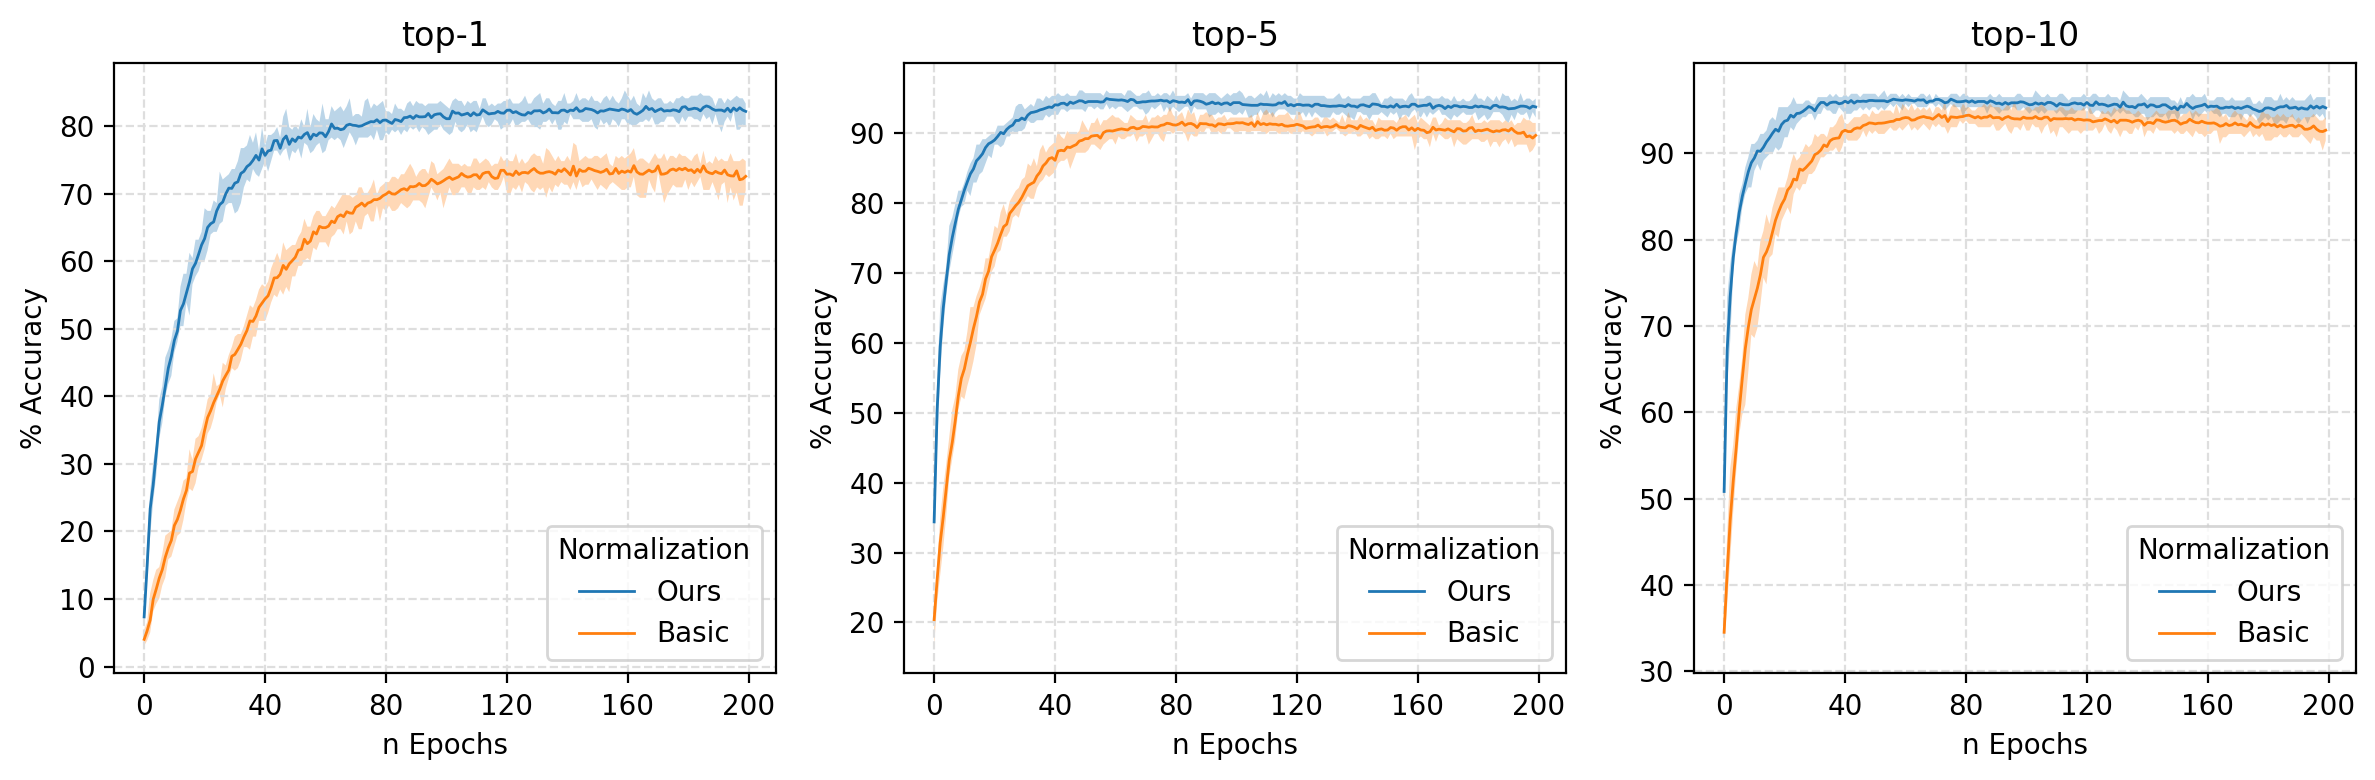

In [73]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ours = joblib.load('results_ours.joblib')                   
base = joblib.load('results_base.joblib')

fig, axes = plt.subplots(ncols=3,  figsize=(12, 4), dpi=200)

ax = axes[0]
ax.set_xticks(np.arange(0, 220, 40))
ax.set_yticks(np.arange(0, 100, 10))
ax.set_ylabel('% Accuracy')
ax.set_xlabel('n Epochs')
ours_mean = np.mean(ours[0], axis=0)
ours_min =np.min(ours[0], axis=0)
ours_max =np.max(ours[0], axis=0)

ax.plot(ours_mean,linewidth=1, label='Ours')
ax.fill_between(np.arange(0, 200), ours_min, ours_max, alpha=0.3)

basic_mean = np.mean(base[0], axis=0)
basic_min =np.min(base[0], axis=0)
basic_max =np.max(base[0], axis=0)

ax.plot(basic_mean,linewidth=1, label='Basic')
ax.fill_between(np.arange(0, 200), basic_min, basic_max, alpha=0.3)
ax.grid(color='0.87', linestyle='--')
ax.legend(title='Normalization')
ax.set_title('top-1')

ax = axes[1]
ax.set_xticks(np.arange(0, 220, 40))
ax.set_yticks(np.arange(0, 100, 10))

ax.set_ylabel('% Accuracy')
ax.set_xlabel('n Epochs')
ours_mean = np.mean(ours[1], axis=0)
ours_min =np.min(ours[1], axis=0)
ours_max =np.max(ours[1], axis=0)

ax.plot(ours_mean,linewidth=1, label='Ours')
ax.fill_between(np.arange(0, 200), ours_min, ours_max, alpha=0.3)

basic_mean = np.mean(base[1], axis=0)
basic_min =np.min(base[1], axis=0)
basic_max =np.max(base[1], axis=0)

ax.plot(basic_mean,linewidth=1, label='Basic')
ax.fill_between(np.arange(0, 200), basic_min, basic_max, alpha=0.3)
ax.grid(color='0.87', linestyle='--')
ax.legend(title='Normalization')
ax.set_title('top-5')


ax = axes[2]
ax.set_xticks(np.arange(0, 220, 40))
ax.set_yticks(np.arange(0, 100, 10))
ax.set_ylabel('% Accuracy')
ax.set_xlabel('n Epochs')
ours_mean = np.mean(ours[2], axis=0)
ours_min =np.min(ours[2], axis=0)
ours_max =np.max(ours[2], axis=0)

ax.plot(ours_mean,linewidth=1, label='Ours')
ax.fill_between(np.arange(0, 200), ours_min, ours_max, alpha=0.3)

basic_mean = np.mean(base[2], axis=0)
basic_min =np.min(base[2], axis=0)
basic_max =np.max(base[2], axis=0)

ax.plot(basic_mean,linewidth=1, label='Basic')
ax.fill_between(np.arange(0, 200), basic_min, basic_max, alpha=0.3)
ax.grid(color='0.87', linestyle='--')
ax.legend(title='Normalization')
ax.set_title('top-10')
plt.tight_layout()
plt.savefig('100model_perf_plot.pdf')
plt.show()

Classes:  100
torch.Size([100, 159]) torch.Size([1]) uint8
Train Data Len 1442
torch.Size([100, 159]) torch.Size([1]) uint8
Val Data Len 338
torch.Size([100, 159]) torch.Size([1]) uint8
Test Data Len 258


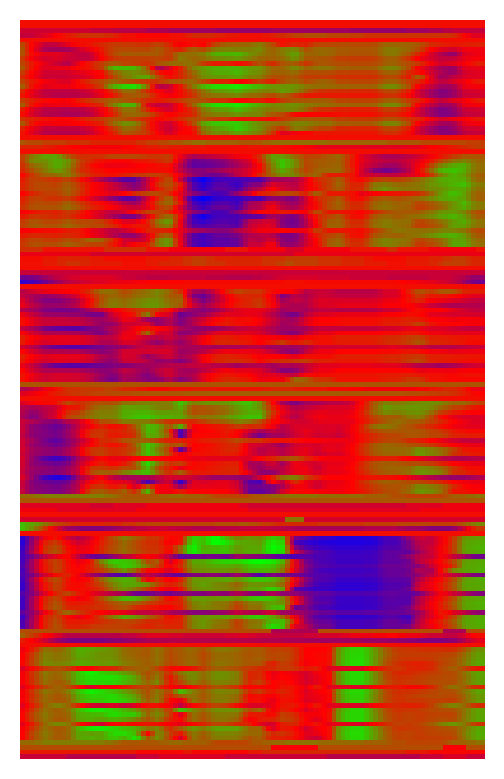

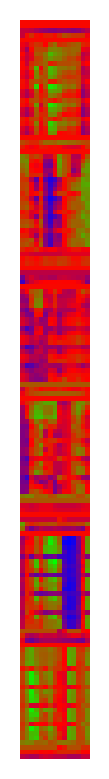

In [2]:
#DRAW SAMPLE AND ADAPTIVE AVG POOL
data_mod = WLASLDataModule('data',100, 1, False)
sample = data_mod.train[0][0]

def plot(x):
    plt.figure(dpi=200)
    plt.axis('off')
    plt.imshow(x,cmap='brg')
    plt.show()
import matplotlib.pyplot as plt

plot(sample.T)

ada_sample = torch.adaptive_avg_pool1d(sample.T,15)
plot(ada_sample)